In [5]:
# !wget https://github.com/logictensornetworks/logictensornetworks/raw/master/examples/multiclass_classification/commons.py
# !pip install ltn keras==2.15.0 -qq

In [6]:
import os
import ltn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    auc,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass
tqdm.pandas()
import matplotlib.pyplot as plt

2025-03-29 19:55:07.252850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 19:55:07.252905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 19:55:07.253909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 19:55:07.260246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-29 19:55:19.440383: W tensorflow/compiler/tf2

In [7]:
ROOT_DIR ='/data/user/home/mhossai5/DPP-New2025'

In [8]:
# Data & Model training arguments
SEED = 42
LR = 0.00001
BATCH_SIZE = 128
FEAT_NAME = [
    'CDKextended',
    'ECFP',
    'ECFP_512',
    'ECFP_2048',
    # 'ChemBERT2_Embedding',
    # 'Llama3-2_Embedding',
    # 'MolWt',
    # 'LogP',
    # 'TPSA',
    # 'HBD',
    # 'HBA',
    # 'RotatableBonds',
]
MODEL_NAME = 'LTN'

TRAIN_HISTORY_PATH = os.path.join(ROOT_DIR, f'results/{"-".join(FEAT_NAME)}-{MODEL_NAME}.csv')

In [9]:
import pandas as pd
import os

# Define the correct path
file_path = os.path.join(ROOT_DIR, "data/dpp4-26-03-25-feat.parquet")

# Read the Parquet file
df_final = pd.read_parquet(file_path)

In [10]:
df_final.head()

,id,smiles,standard_value,standard_type,standard_units,target_organism,target_pref_name,pIC50,source,label,...,ECFP_512,Llama3-2_Embedding,ChemBERT2_Embedding,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,Physiochemical
0,CHEMBL93558,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,217000.0,IC50,nM,Homo sapiens,Dipeptidyl peptidase IV,3.663540,ChEMBL,inactive,...,"[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.49902532, 2.9190297, -0.23703773, -0.25883...","[-0.38957188, -0.6216704, 0.4703551, 0.1626513...",238.375,2.2966,46.33,1.0,2.0,3.0,"[238.37499999999994, 2.2966000000000006, 46.33..."
1,CHEMBL443622,C[C@H](N)C(=O)N1CCCC1,41000.0,IC50,nM,Homo sapiens,Dipeptidyl peptidase IV,4.387216,ChEMBL,inactive,...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9239326, 2.7885501, 0.38945127, 0.3505689,...","[-0.3062373, -0.24003226, 0.14207578, 0.525902...",142.202,-0.0440,46.33,1.0,2.0,1.0,"[142.20199999999997, -0.04400000000000004, 46...."
2,CHEMBL403882,O=C([C@@H]1CCCN1)N1CCCC1,15000.0,IC50,nM,Homo sapiens,Dipeptidyl peptidase IV,4.823909,ChEMBL,inactive,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.41079238, 2.760039, 0.025078857, -0.101544...","[-0.3257358, -0.012994111, 0.17750713, -0.0522...",168.240,0.3608,32.34,1.0,2.0,1.0,"[168.23999999999998, 0.3608, 32.34, 1.0, 2.0, ..."
3,CHEMBL328655,S=C(C1CCCN1)N1CCCC1,500000.0,IC50,nM,Homo sapiens,Dipeptidyl peptidase IV,3.301030,ChEMBL,inactive,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.13337657, 2.8452492, 0.630767, 0.08860778,...","[-0.0054997415, -0.37361592, 0.015422794, 0.30...",184.308,1.1616,15.27,1.0,2.0,1.0,"[184.30799999999996, 1.1616, 15.27, 1.0, 2.0, ..."
4,CHEMBL328795,NC(=O)CC(N)C(=O)N1CCCC1,188000.0,IC50,nM,Homo sapiens,Dipeptidyl peptidase IV,3.725842,ChEMBL,inactive,...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.6948919, 2.6412396, 0.3524785, -0.21108356...","[-0.6008385, -0.16555355, 0.1292091, 0.9035775...",185.227,-1.1885,89.42,2.0,3.0,3.0,"[185.22699999999995, -1.1885000000000001, 89.4..."


In [13]:
df_final.shape

(6563, 25)

In [16]:
df_final.list['source']

AttributeError: 'DataFrame' object has no attribute 'list'

In [7]:
X = np.concatenate([np.vstack(df_final[df_final['splits']=='train'][col]) for col in FEAT_NAME],axis = 1)
y = df_final[df_final['splits']=='train']['target']

X_test = np.concatenate([np.vstack(df_final[df_final['splits']=='test'][col]) for col in FEAT_NAME],axis = 1)
y_test = df_final[df_final['splits']=='test']['target']
X = np.nan_to_num(X)
X_test = np.nan_to_num(X_test)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.05,random_state = SEED,stratify=y)

In [8]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('X_val: ', X_val.shape)

X_train:  (4987, 4608)
X_test:  (1313, 4608)
X_val:  (263, 4608)


In [9]:
scaler = StandardScaler()

# Fit the scaler on the training data only
scaler.fit(X_train)

# Transform the train, validation, and test sets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE).shuffle(512,seed= SEED)
ds_val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

2025-03-28 22:40:10.852176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# LTN

#Predicate with softmax `P(x,class)`

In [12]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(768,384,192)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="relu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.25)

    def call(self, inputs, training=False):
        x = inputs[0]
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)
tf.keras.backend.clear_session()
logits_model = MLP(2)
p = ltn.Predicate.FromLogits(logits_model, activation_function="softmax", with_class_indexing=True)

In [13]:
# Constants to index/iterate on the classes

In [14]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)

In [15]:
# Operators and axioms

In [16]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [17]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=4))

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
    ]

    for i in range(len(axioms)):
        if tf.math.is_nan(axioms[i].tensor):
            axioms[i].tensor = tf.constant(0,axioms[i].tensor.dtype)
    sat_level = formula_aggregator(axioms).tensor

    return sat_level

In [18]:
# Initialize all layers and the static graph

In [19]:
for features, labels in ds_val:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

Initial sat level 0.38536


In [20]:
# Training

# Define the metrics. While training, we measure:
# 1. The level of satisfiability of the Knowledge Base of the training data.
# 1. The level of satisfiability of the Knowledge Base of the test data.
# 3. The training accuracy.
# 4. The test accuracy.

In [21]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'val_sat_kb': tf.keras.metrics.Mean(name='val_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'val_accuracy': tf.keras.metrics.CategoricalAccuracy(name="val_accuracy"),
    # 'train_auc': tf.keras.metrics.AUC(name="train_auc"),
    # 'val_auc': tf.keras.metrics.AUC(name="val_auc"),
}

In [22]:
# Define the training and test step

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model([features])
    metrics_dict['train_accuracy'](tf.one_hot(labels,2),predictions)

@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['val_sat_kb'](sat)
    # accuracy
    predictions = logits_model([features])
    metrics_dict['val_accuracy'](tf.one_hot(labels,2),predictions)

In [24]:
import commons

EPOCHS = 100

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_val,
    train_step,
    test_step,
    csv_path=TRAIN_HISTORY_PATH,
    track_metrics=1
)

Epoch 0, train_sat_kb: 0.4915, val_sat_kb: 0.5453, train_accuracy: 0.5881, val_accuracy: 0.6958
Epoch 1, train_sat_kb: 0.5700, val_sat_kb: 0.5960, train_accuracy: 0.7524, val_accuracy: 0.8023
Epoch 2, train_sat_kb: 0.6180, val_sat_kb: 0.6254, train_accuracy: 0.8328, val_accuracy: 0.8365
Epoch 3, train_sat_kb: 0.6552, val_sat_kb: 0.6478, train_accuracy: 0.8695, val_accuracy: 0.8593
Epoch 4, train_sat_kb: 0.6856, val_sat_kb: 0.6633, train_accuracy: 0.8975, val_accuracy: 0.8821
Epoch 5, train_sat_kb: 0.7117, val_sat_kb: 0.6890, train_accuracy: 0.9128, val_accuracy: 0.8973
Epoch 6, train_sat_kb: 0.7338, val_sat_kb: 0.6968, train_accuracy: 0.9256, val_accuracy: 0.9011
Epoch 7, train_sat_kb: 0.7473, val_sat_kb: 0.7054, train_accuracy: 0.9330, val_accuracy: 0.9049
Epoch 8, train_sat_kb: 0.7646, val_sat_kb: 0.7303, train_accuracy: 0.9441, val_accuracy: 0.9163
Epoch 9, train_sat_kb: 0.7814, val_sat_kb: 0.7356, train_accuracy: 0.9495, val_accuracy: 0.9202
Epoch 10, train_sat_kb: 0.7915, val_sat_

In [25]:
# Model save weights
logits_model.save(os.path.join(ROOT_DIR,f'weights/DPP4_{MODEL_NAME}_{"-".join(FEAT_NAME)}_Weights.keras'))

In [26]:
y_pred_prob = tf.nn.softmax(logits_model.predict([X_test])).numpy()
y_pred = y_pred_prob.argmax(-1)

42/42 [==============================] - 0s 4ms/step


In [27]:
np.savez(
    os.path.join(ROOT_DIR,'results',f'DPP4-{MODEL_NAME}-{"-".join(FEAT_NAME)}-Preditions'),
    y_true = y_test,
    y_pred_prob = y_pred_prob,
    )

In [28]:
print(f"accuracy_score: {accuracy_score(y_test,y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test,y_pred)}")
print(f"matthews_corrcoef: {matthews_corrcoef(y_test,y_pred)}")
print(f"F1 Score: {f1_score(y_test,y_pred,average='macro')}")


accuracy_score: 0.9725818735719726
roc_auc_score: 0.9719222992895454
matthews_corrcoef: 0.9446872371636874
F1 Score: 0.972322934232715


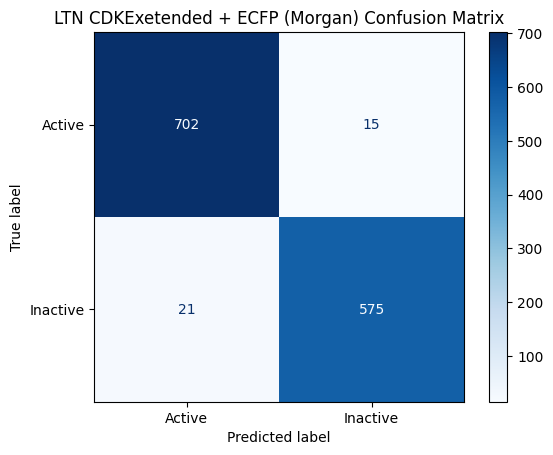

In [29]:
cm = confusion_matrix(y_test, y_pred)

# 6. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ['Active', 'Inactive'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"LTN CDKExetended + ECFP (Morgan) Confusion Matrix")
plt.show()

In [30]:
hist = pd.read_csv(TRAIN_HISTORY_PATH)


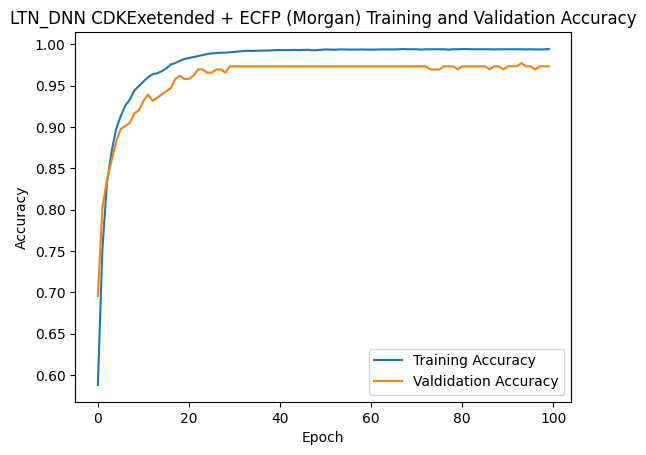

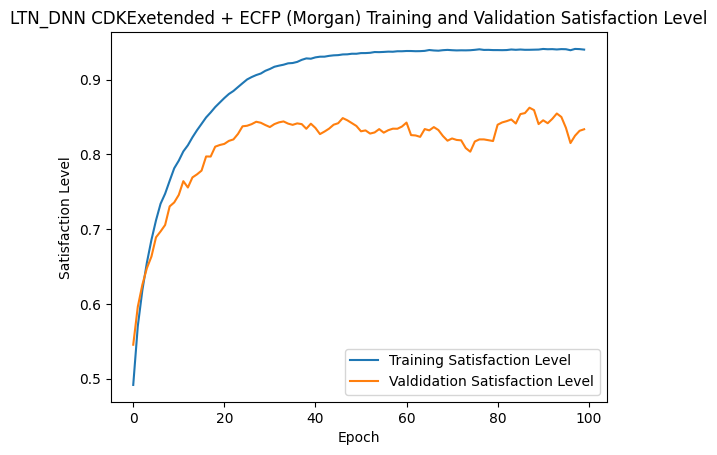

In [31]:
plt.title(f'{MODEL_NAME.upper()} CDKExetended + ECFP (Morgan) Training and Validation Accuracy')
plt.plot(hist['train_accuracy'],label= 'Training Accuracy')
plt.plot(hist['val_accuracy'],label= 'Valdidation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.title(f'{MODEL_NAME.upper()} CDKExetended + ECFP (Morgan) Training and Validation Satisfaction Level')
plt.plot(hist['train_sat_kb'],label= 'Training Satisfaction Level')
plt.plot(hist['val_sat_kb'],label= 'Valdidation Satisfaction Level')
plt.ylabel('Satisfaction Level')
plt.xlabel("Epoch")
plt.legend()
plt.show()